In [4]:
!pwd

/kaggle/input/code-21/mae


In [5]:
cd ../../../input/code-22/mae

/kaggle/input/code-22/mae


In [15]:
!python main_pretrain.py --output_dir ../../../working/output --epochs 20 --input_height 240 --input_width 272 --norm_pix_loss --warmup_epochs 20 --data_dir ../../images/ResizedDataset --log_dir ../../../working/logs --num_workers 4 --local_rank 0

2024-04-21 12:15:08.536915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 12:15:08.536973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 12:15:08.538415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Not using distributed mode
[12:15:12.884137] job dir: /kaggle/input/code-22/mae
[12:15:12.884222] Namespace(batch_size=64,
epochs=20,
accum_iter=1,
model='mae_vit_large_patch16',
input_height=240,
input_width=272,
mask_ratio=0.75,
norm_pix_loss=True,
weight_decay=0.05,
lr=None,
blr=0.001,
min_lr=0.0,
warmup_epochs=20,
data_dir='../../images/ResizedDataset',
outpu

In [16]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

In [17]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    #random_filename = str(uuid.uuid4()) + '.jpg'
    image = (torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()).numpy().astype(np.uint8)
    plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.imsave('../../../working/image1.jpg', image)
    return

In [18]:
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)(img_width=272, img_height=240)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

In [19]:
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y, 240, 272)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, 240, 272)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    # Plotting
    plt.figure()

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    # Adjust layout to prevent overlapping axes
    plt.tight_layout()

    plt.show()


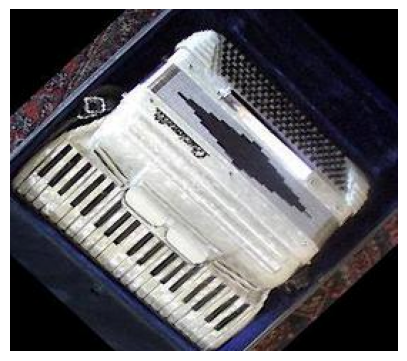

In [20]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_path = '../../test-images/NewImgs/image_0011.jpg'
img = Image.open(img_path)
# img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (240, 272, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [21]:
chkpt_dir = '../../../working/output/checkpoint-19.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


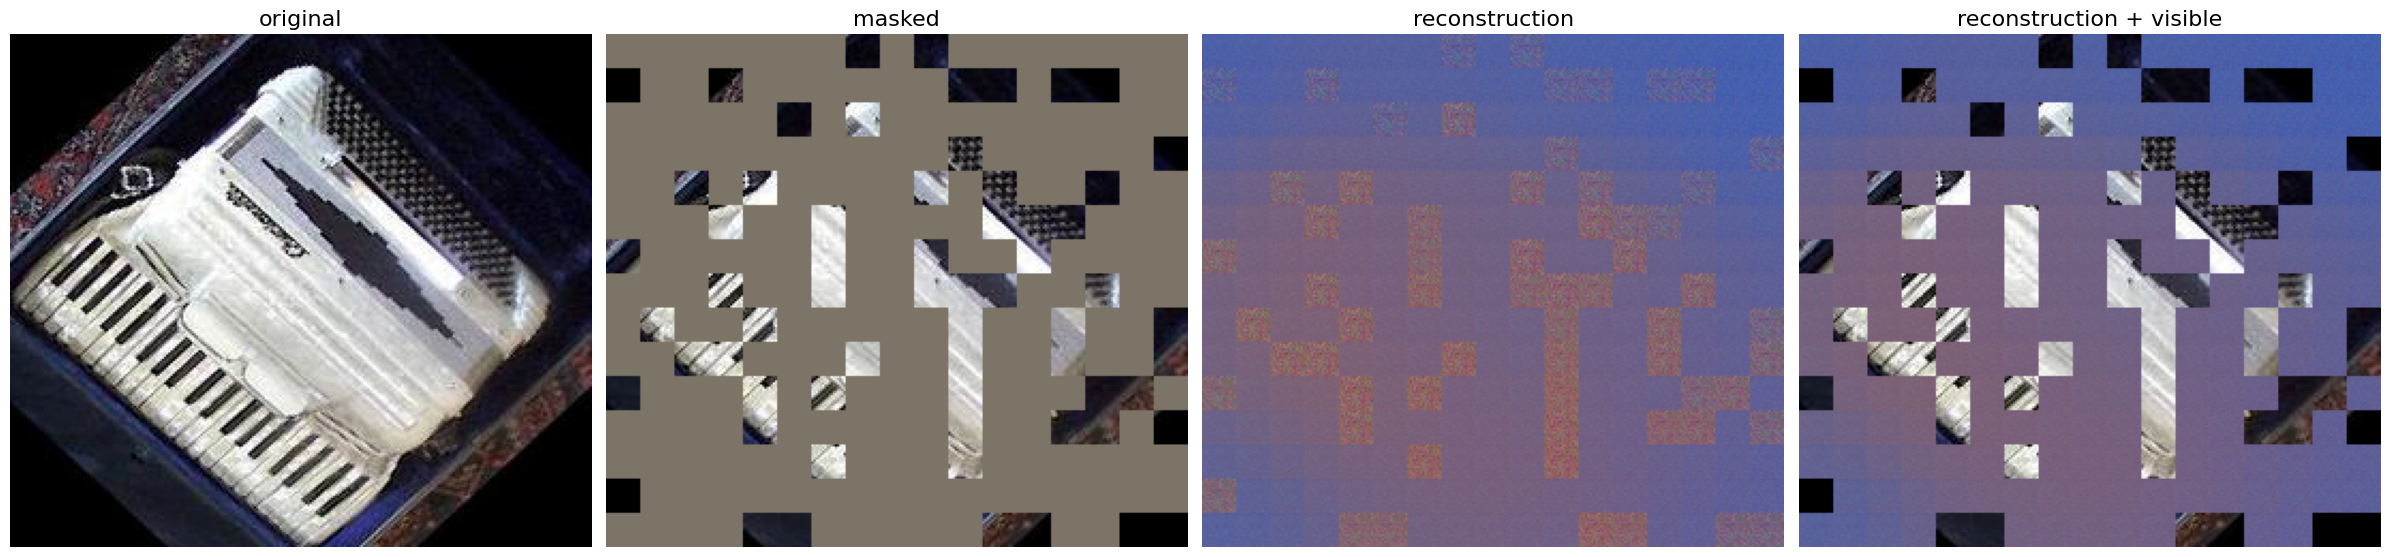

In [22]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)